# Homogeneous Representations of Spectroscopic Data Cubes 
# Part 1: REPRESENTATIONS
## Astronomy and Computing Journal, 2017
### Mauricio Araya (1), Diego Mardones (2), Marcelo Mendoza (1), Mauricio Solar (1) and Amelia Bayo (3)

(1) Universidad Técnica Federico Santa María <br>
(2) Universidad de Chile
(3) Universidad de Valparaíso

# 1. Introduction

This notebook contains the code for replicating the experiments presented in the paper "Homogeneous Representations of Spectroscopic Data Cubes". First, you need to download and install the development version of the library `acalib` from github. (part 1)

> git clone acalib

> python setup.py

(The pip version is not useful).

### Imports and Initialization

In [1]:
#%matplotlib qt
%matplotlib inline

import acalib

### Downloading Data

Our data set is composed by a few spectroscopic cubes from the [ALMA Science Verification Dataset](https://almascience.nrao.edu/alma-data/science-verification). The following code download, uncompress and rename the files for its use.


In [2]:
import os
import urllib.request
import tarfile
from shutil import copyfile

DOWNLOADS_DIR = 'data/'

# Data from ALMA science verification 

# URLs of the tarballs
urls  = ['https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz',
         'https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz',
         #'https://bulk.cv.nrao.edu/almadata/sciver/AntennaeBand7/Antennae_Band7_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz']

# Fits names and their "fantasy" names 
flist  = [('Orion.methanol.cbc.contsub.image.fits',          'Orion-CH3OH'),
          ('TWHydra_CO3_2line.image.fits',                   'TWHydra-CO3_2'),
          ('M100line.image.fits',                            'M100-CO1_0'),
          #('Antennae_North.CO3_2Line.Clean.pcal1.image.fits','AntennaeN-CO3_'),
          ('I16293_220GHzcorrected.ms.selfcube.image.fits',  'IRAS16293-2422-HCOCH')]

fits_map=dict(zip(urls, flist))

for url,ffile in fits_map.items():
    # Split on the rightmost / and take everything on the right side of that
    name = url.rsplit('/', 1)[-1]
    # Combine the name and the downloads directory to get the local filename
    filename = os.path.join(DOWNLOADS_DIR, name)
    if not os.path.isfile(filename):
        print("Downloading "+str(url))
        urllib.request.urlretrieve(url, filename)
    else:
        print("File found, skipping download of "+str(url))
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    #print(sdir)
    if not os.path.isdir(sdir):
        print("Uncompressing "+str(filename))
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()
    else:
        print("Directory "+str(sdir)+ " found, not uncompressing")
    copyfile(sdir+"/"+ffile[0], DOWNLOADS_DIR+"/"+ffile[0])

File found, skipping download of https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz
Directory data/IRAS16293_Band6_ReferenceImages found, not uncompressing
File found, skipping download of https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz
Directory data/OrionKL_Band6_ReferenceImages found, not uncompressing
File found, skipping download of https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz
Directory data/M100_Band3_ReferenceImages found, not uncompressing
File found, skipping download of https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz
Directory data/TWHYA_BAND7_ReferenceImages found, not uncompressing


### Dataset Description

The summary of the dimensions and resolutions of the downloaded cubes are obtained using the following extracting function from the FITS metadata.

In [3]:
import numpy as np
def extract_info(path,ffile):
    # Load fits file  using astropy and convert the primary image into an NDArray
    cube = acalib.load(path+ffile[0])
    #target  = cube.meta['OBJECT']
    
    valid   = 100*(1.0- (cube.mask.sum()/float(cube.data.size)))
    b_size  = cube.meta['BMIN']
    s_res   = np.abs(cube.meta['CDELT3'])
    a_res   = np.abs(cube.meta['CDELT1'])
    return (ffile[1],cube.data.shape,cube.data.size,valid,a_res,b_size,s_res)

Which are putted in a table for better visualization.

In [4]:
from astropy.table import Table

summary=Table(names=('Name', 
                     '(RA, DEC, FREQ)',
                     'Pixels',
                     'Valid %',
                     'Ang. Res',
                     'Beam Size',
                     'Spec. Res'),
             dtype=('S100',tuple,int,float,float,float,float))

for ffile in flist :
    summary.add_row(vals=extract_info(DOWNLOADS_DIR,ffile))

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


Show the table in the notebook and in latex format

In [5]:
summary

Name,"(RA, DEC, FREQ)",Pixels,Valid %,Ang. Res,Beam Size,Spec. Res
bytes100,object,int64,float64,float64,float64,float64
Orion-CH3OH,"(41, 100, 100)",410000,100.0,0.000111111111111,0.000382384558519,488336.120789
TWHydra-CO3_2,"(118, 100, 100)",1180000,100.0,8.33333333333e-05,0.000425537294812,138414.151856
M100-CO1_0,"(40, 600, 600)",14400000,57.7954722222,0.000138888888889,0.000689453085264,3906250.0
IRAS16293-2422-HCOCH,"(480, 220, 220)",23232000,53.7582644628,5.55555555556e-05,0.000275483561887,488311.0


In [6]:
# Generating the latex table for the paper
from astropy.io import ascii
ascii.write(summary,format='latex') 

\begin{table}
\begin{tabular}{ccccccc}
Name & (RA, DEC, FREQ) & Pixels & Valid % & Ang. Res & Beam Size & Spec. Res \\
Orion-CH3OH & (41, 100, 100) & 410000 & 100.0 & 0.000111111111111 & 0.000382384558519 & 488336.120789 \\
TWHydra-CO3_2 & (118, 100, 100) & 1180000 & 100.0 & 8.33333333333e-05 & 0.000425537294812 & 138414.151856 \\
M100-CO1_0 & (40, 600, 600) & 14400000 & 57.7954722222 & 0.000138888888889 & 0.000689453085264 & 3906250.0 \\
IRAS16293-2422-HCOCH & (480, 220, 220) & 23232000 & 53.7582644628 & 5.55555555556e-05 & 0.000275483561887 & 488311.0 \\
\end{tabular}
\end{table}


# 2. Signal-to-Noise-Ratio Estimation (SNR)

In this section we show how the signal-to-noise estimation is done.  
Before doing this we define here a function to plot the results.

### The `plot_snr_estimation()` function
This function plots the thresholded RMS w.r.t. the SNR, including and the selected SNR point. More details below.

In [7]:
import matplotlib.pyplot as plt

def plot_snr_estimation(target,snr_results):
    fig = plt.figure(figsize=(10,4))
    # Unpack results
    (slimit,rms,x,y,v,n,p)=snr_results
    # Plot 
    ax = fig.add_subplot(1,1,1)
    ax.plot(x,y,color='b')
    ax.plot(x,x,color='b',linestyle="--")
    ax.axvline(x=slimit,color='r',label="$"+str(slimit)+" \sigma$")
    ax.legend(loc=7)
    ax.set_title(target)
    ax.set_xlabel("SNR ($ \\tau / \sigma$)")
    ax.set_ylabel('RMS', color='b')
    for tl in ax.get_yticklabels():
        tl.set_color('b')
    axp = ax.twinx()
    axp.plot(x[:-1],v,color='grey')
    axp.set_ylabel('$\Delta$RMS', color='grey')
    for tl in axp.get_yticklabels():
        tl.set_color('grey')
    plt.show()
    

### Compute, store and plot the estimations
The fluxes of each cube are standardized in the $[0,1]$ range to ensure numerical stability using the function `aca.standarize`. Then, the parameter $\sigma$ of the algorithm is estimated as the RMS of the cube and an estimation of the signal-to-noise ratio is performed to obtain the $\tau$ parameter by using function `aca.snr_estimation()`. Then we plot the results using the previous function. At last, we compute the theoretical bound reported in the paper:
\begin{equation*}
\frac{F_\tau - n_\tau(\tau - \sigma)}{\sigma}
\end{equation*}
and store the results into a table.

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


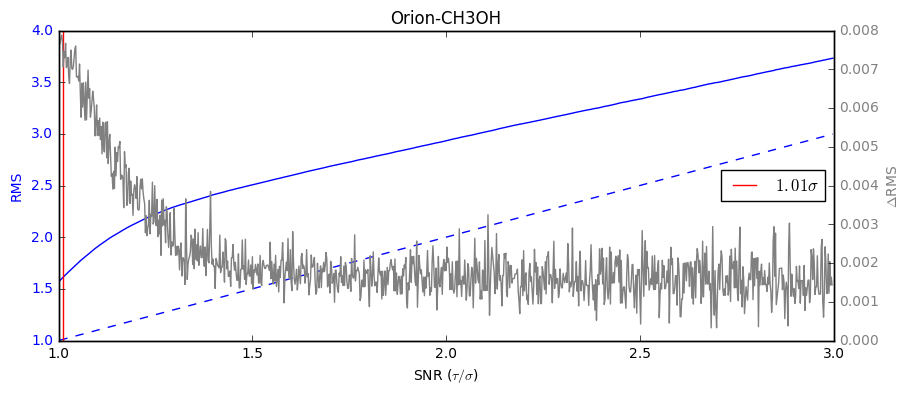

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


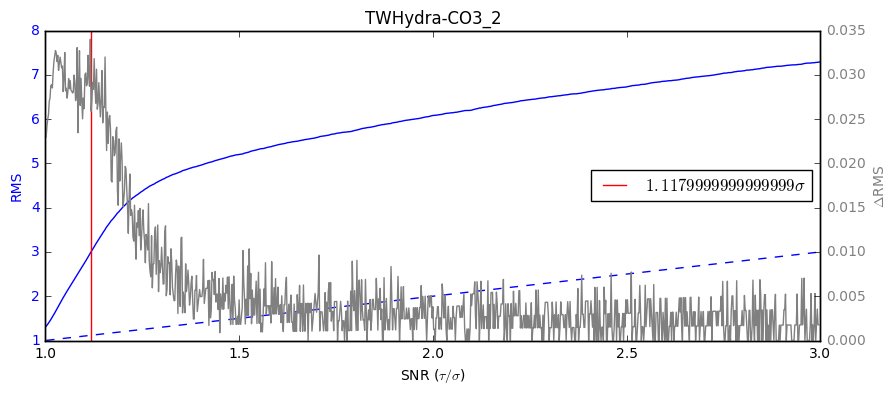

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/mauricio/scm/acalib-maray/acalib/core/statistics.py:58: RuntimeWarning: invalid value encountered in greater
  sdata = data[data > noise]


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


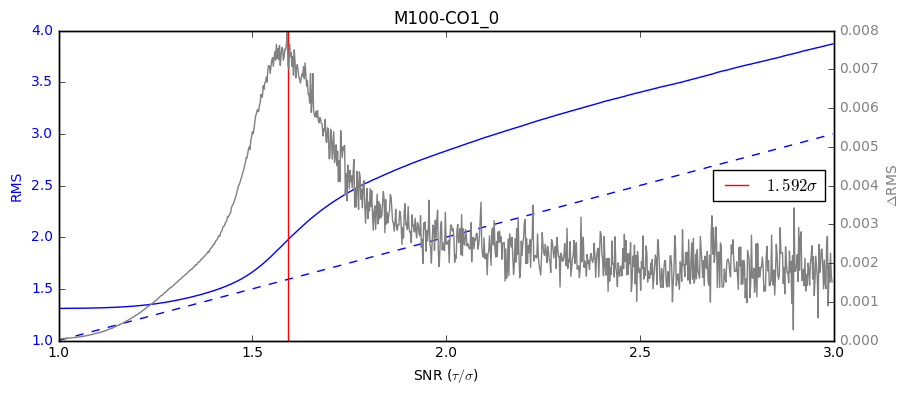

/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


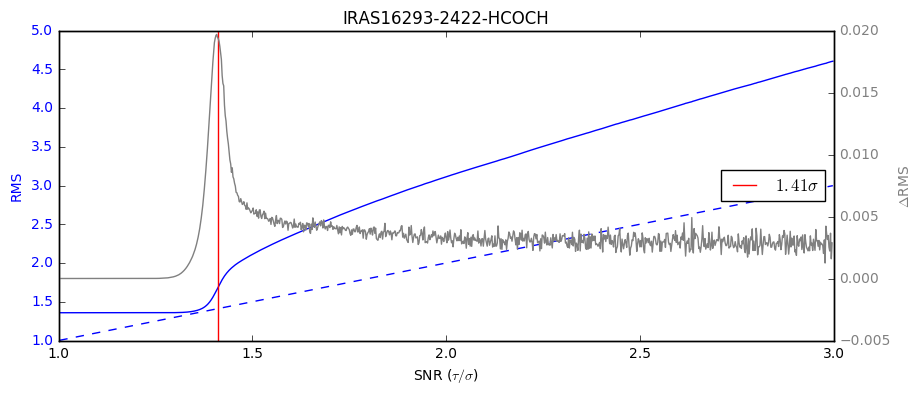

In [8]:
# Define the snr_table elements
snr_table=Table(names=('Name', 
                       'RMS',
                       'SNR',
                       'N_max'),
             dtype=('S100',float,float,float))

for ffile in flist:
    
    # Read file
    cube    = acalib.load(DOWNLOADS_DIR+ffile[0])
    target  = ffile[1]
    
    # Process it
    (cube,ym,yf)=acalib.standarize(cube)
    result=acalib.core.snr_estimation(cube.data,mask=cube.mask,points=1000,full_output=True)
    # Display it
    plot_snr_estimation(target,result)
    
    # Unpack, and compute the theoretical maximum number of elements 
    (slimit,rms,x,y,v,n,p)=result
    F=cube.data[cube.data>slimit*rms]
    nt=F.shape[0]
    Ft=F.sum()
    nest=(Ft - nt*(slimit*rms - rms))/rms
    snr_table.add_row(vals=(target,rms,slimit,nest))

The blue lines correspond to the RMS computed after
thresholding the cube using $\tau$. The dotted line is the lowest value that the
RMS can take, the grey line shows the slope of the RMS and the red line is the
SNR selected by the heuristic.

### Summary table

In [9]:
snr_table

Name,RMS,SNR,N_max
bytes100,float64,float64,float64
Orion-CH3OH,2.60771895779e-06,1.01,66983.2529307
TWHydra-CO3_2,8.99479067679e-07,1.118,25850.2002163
M100-CO1_0,9.18094227979e-08,1.592,103608.136824
IRAS16293-2422-HCOCH,5.8952157086e-08,1.41,348146.148709


# 3. Pixel-based Homogeneous Representation (PHB)

This section shows some graphical results for a pixel-based homogeneous representation.

### Graphical layout
To show these results we require some "advanced" matplotlib configurations to improve the visualization.

In [10]:
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['axes.formatter.limits']=(-5,5)
def fmt(x, pos):
    return '{:.1e}'.format(x)

For each file we will produce 4 plots:
* The original zeroth moment of the cube (`orig2D`)
* The signal (i.e. synthethic) zeroth moment of the cube (`syn2D`)
* The residual (i.e. original - signal) zeroth moment of the cube (`res2D`)
* The integrated spectrum of the these three cubes (`origSpec`,`synSpec`,`resSpec`)

The following large function plots these elements starting from the `cube`, `syn` and `res` data. Most of the code is only for a proper visualization.

In [11]:

def plot_algo_result(target,cube,syn,res):
    ### Stylistic configurations ###
    cmap="seismic"
    origin="lower"
  
    # Relative sizes of the subfigure
    fig = plt.figure(target,figsize=(10,5))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1 , 3], height_ratios=[1,1,1,1]) 
    ### END ###
    
    # Obtain the zeroth moments
    orig2D=acalib.moment0(cube)
    syn2D=acalib.moment0(syn,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    res2D=acalib.moment0(res,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    
    # Shared colormap minimum and maximum values
    vmin=0
    vmax=orig2D.data.max()
    
    # Obtain the spectra
    origSpec=np.nansum(cube.data,axis=(1,2))
    synSpec=syn.sum(axis=(1,2))
    resSpec=res.sum(axis=(1,2))
    
    # First image with WCS and name
    ax1  = plt.subplot(gs[0],projection=orig2D.wcs)
    ob=ax1.imshow(orig2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax1.set_title("Original")
    ax1.set_ylabel(target)
   
    # Second image without WCS
    ax2  = plt.subplot(gs[1])
    ax2.imshow(syn2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("Signal")
    
    # Third image without WCS
    ax3  = plt.subplot(gs[2])
    ax3.imshow(res2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title("Residual")

    # Add a colorbar
    cb=fig.colorbar(ob,ax=[ax1,ax2,ax3], format=ticker.FuncFormatter(fmt))
    cb.set_label("Flux")
    
    # Plot the 3 spectra with proper velocity values (from cube's resfrq)
    ax4  = plt.subplot(gs[3])
    ranges = acalib.extent(cube)
    vel = np.linspace(ranges[0][0], ranges[1][0], cube.data.shape[0])
    ax4.plot(vel,origSpec,color='k',label='Original')
    ax4.plot(vel,resSpec,color='k',linestyle="--",label='Residual')
    ax4.set_xlabel("Velocity [km/s]")
    ax4.set_ylabel("Flux")
    for tl in ax4.get_yticklabels():
        tl.set_color('k')
    ax5=ax4.twinx()
    ax5.plot(vel,synSpec,color='b',label='Signal',linewidth=2.0)
    for tl in ax5.get_yticklabels():
        tl.set_color('b')
    ax4.legend(loc=2)
    ax5.legend(loc=1)
    plt.show()


### PHB Representation Results

**TODO**: need to create algorithms for this in acalib.algorithms rather than using core

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


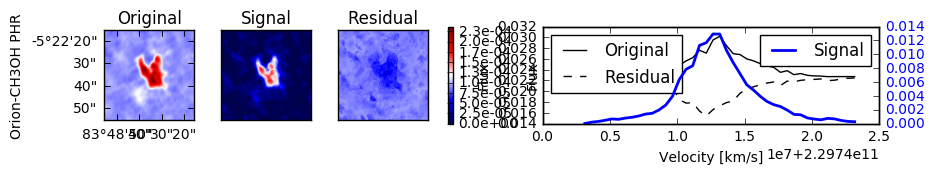

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


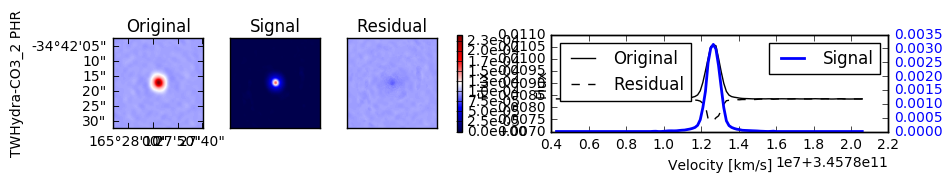

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/mauricio/scm/acalib-maray/acalib/core/compact_rep.py:101: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


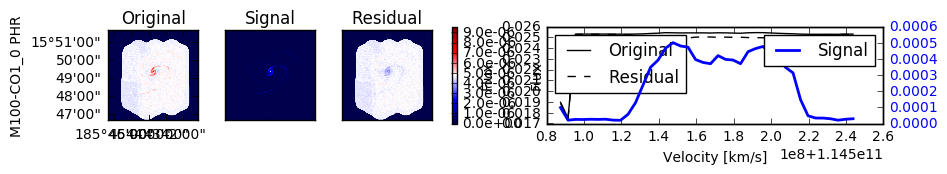

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/mauricio/scm/acalib-maray/acalib/core/compact_rep.py:101: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


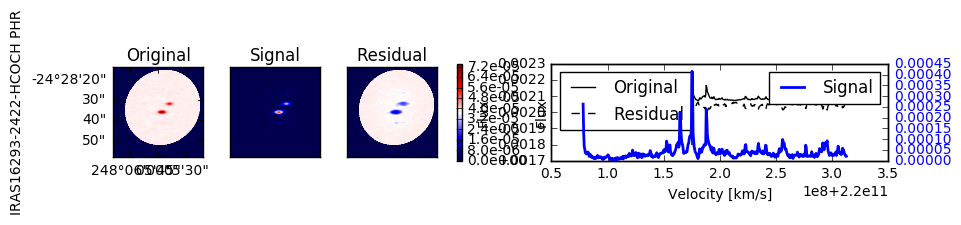

In [12]:

from acalib.core.compact_rep import *
from matplotlib import gridspec
rep_size=[]
bound=[]
count=0
for ffile in flist:
    
    cube    = acalib.load(DOWNLOADS_DIR+ffile[0])
    target  = ffile[1]
  
    (cube,ym,yf)=acalib.standarize(cube)
    mynoise=snr_table['RMS'][count]
    mythresh=mynoise*snr_table['SNR'][count]
    (rep,syn,res)=scatpix_detect(cube.data,threshold=mythresh,noise=mynoise,full_output=True)

    mmmask=(syn>0)
    nnn=syn[mmmask].size
    ft=np.nansum(syn[mmmask] + res[mmmask]) 
    
    bound.append(int((ft -nnn*(mythresh - mynoise))/mynoise))
    rep_size.append(rep.as_array().size)
    
    plot_algo_result(target+" PHR",cube,syn,res)
    
    count+=1

### PHR dimensions
Here we present the number of points needed by a PHR solution given the computed SNR, and we compare it with respect to the theoretical bound and the number of valid pixels of the image. Also, the latex version of the table is printed.

In [13]:
from astropy.table import Column
phr_table=snr_table.copy()
rbound=Column((np.array(rep_size)*100/np.array(bound))/100.0,name="Pts/Bound")
elms=Column(rep_size,name="Pts")
pval=np.array(rep_size)/(summary['Pixels']*(summary['Valid %']/100.0))
pval.name="Pts/Valid"
phr_table.remove_column('N_max')
phr_table.add_columns((elms,rbound,pval))
phr_table

Name,RMS,SNR,Pts,Pts/Bound,Pts/Valid
bytes100,float64,float64,int64,float64,float64
Orion-CH3OH,2.60771895779e-06,1.01,55964,0.835495573504,0.136497560976
TWHydra-CO3_2,8.99479067679e-07,1.118,23796,0.920541586074,0.0201661016949
M100-CO1_0,9.18094227979e-08,1.592,101890,0.98341826886,0.0122426449208
IRAS16293-2422-HCOCH,5.8952157086e-08,1.41,328044,0.942259856497,0.0262663822591


In [14]:
ascii.write(phr_table,format='latex')

\begin{table}
\begin{tabular}{cccccc}
Name & RMS & SNR & Pts & Pts/Bound & Pts/Valid \\
Orion-CH3OH & 2.60771895779e-06 & 1.01 & 55964 & 0.835495573504 & 0.136497560976 \\
TWHydra-CO3_2 & 8.99479067679e-07 & 1.118 & 23796 & 0.920541586074 & 0.0201661016949 \\
M100-CO1_0 & 9.18094227979e-08 & 1.592 & 101890 & 0.98341826886 & 0.0122426449208 \\
IRAS16293-2422-HCOCH & 5.8952157086e-08 & 1.41 & 328044 & 0.942259856497 & 0.0262663822591 \\
\end{tabular}
\end{table}


## 4. Gaussian-based Homogeneous Representation (GHR)

In [20]:
def camera_ready_algo_result(target,cube,syn,res,synP,resP):
    ### Stylistic configurations ###
    cmap="seismic"
    origin="lower"
  
    # Relative sizes of the subfigure
    fig = plt.figure(target)#,figsize=(10,5))
    gs = gridspec.GridSpec(1, 5)# width_ratios=[1, 1, 1 , 1,1], height_ratios=[1,1,1,1,1]) 
    ### END ###
    
    # Obtain the zeroth moments
    orig2D=acalib.moment0(cube)
    syn2D=acalib.moment0(syn,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    res2D=acalib.moment0(res,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    
    synP2D=acalib.moment0(synP,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    resP2D=acalib.moment0(resP,wcs=cube.wcs,mask=cube.mask,unit=cube.unit)
    

    # Shared colormap minimum and maximum values
    vmin=0
    vmax=orig2D.data.max()
    
    # Obtain the spectra
    origSpec=np.nansum(cube.data,axis=(1,2))
    synSpec=syn.sum(axis=(1,2))
    resSpec=res.sum(axis=(1,2))
    synPSpec=synP.sum(axis=(1,2))
    resPSpec=resP.sum(axis=(1,2))
    
    
    # First image with WCS and name
    ax1  = plt.subplot(gs[0],projection=orig2D.wcs)
    ob=ax1.imshow(orig2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax1.set_title("Original")
    ax1.set_ylabel(target)
   
    # Second image without WCS
    ax2  = plt.subplot(gs[1])
    ax2.imshow(synP2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("PHR Signal")
  
 
    ax3  = plt.subplot(gs[2])
    ax3.imshow(syn2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title("GHR Signal")

    ax4  = plt.subplot(gs[3])
    ax4.imshow(resP2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    ax4.set_title("PHR Residual")
 
    ax5  = plt.subplot(gs[4])
    ax5.imshow(res2D.data,origin=origin,vmin=vmin,vmax=vmax,cmap=cmap)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.set_title("GHR Residual")

    # Add a colorbar
    cb=fig.colorbar(ob,ax=[ax1,ax2,ax3,ax4,ax5], format=ticker.FuncFormatter(fmt))
    cb.set_label("Flux")
    plt.show()
    plt.figure()    
    # Plot the 3 spectra with proper velocity values (from cube's resfrq)
    axn  = plt.subplot(1,1,1)
    ranges = acalib.extent(cube)
    vel = np.linspace(ranges[0][0], ranges[1][0], cube.data.shape[0])
    axn.plot(vel,origSpec,color='k',label='Original',linewidth=2.0)
    axn.plot(vel,resPSpec,color='b',label='PHR Residual',linewidth=2.0)
    axn.plot(vel,resSpec,color='r',label='GHR Residual',linewidth=2.0)
    axn.set_xlabel("Velocity [km/s]")
    axn.set_ylabel("Flux")
    for tl in axn.get_yticklabels():
        tl.set_color('k')
    axnp=axn.twinx()
    axnp.plot(vel,synPSpec,color='b',linestyle=":",label='PHR Signal',linewidth=2.0)
    axnp.plot(vel,synSpec,color='r',linestyle=":",label='GHR Signal',linewidth=2.0)
    for tl in axnp.get_yticklabels():
        tl.set_color('Gray')
    axn.legend(loc=2)
    axnp.legend(loc=1)
    plt.show()    
    
    #axn  = plt.subplot(2,1,2)
    #ranges = aca.extent(cube)
    #vel = np.linspace(ranges[0][0], ranges[1][0], cube.data.shape[0])
    #axn.plot(vel,origSpec,color='k',label='Original')
    #axn.plot(vel,resSpec,color='k',linestyle="--",label='Residual')
    #axn.set_xlabel("Velocity [km/s]")
    #axn.set_ylabel("Flux")
    #for tl in axn.get_yticklabels():
    #    tl.set_color('k')
    #axnp=axn.twinx()
    #axnp.plot(vel,synSpec,color='b',label='Signal',linewidth=2.0)
    #for tl in axnp.get_yticklabels():
    #    tl.set_color('b')
    #axn.legend(loc=2)
    #axnp.legend(loc=1)


INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
CPU times: user 424 ms, sys: 0 ns, total: 424 ms
Wall time: 425 ms
2.63379614737e-06 2.60771895779e-06 [1, 2.0, 2.0]
INFO: Iteration: 1000 [acalib.core.compact_rep]
INFO: Maximum energy E = 7.13003e-06 SNR = 2.73419997015 [acalib.core.compact_rep]
INFO: Iteration: 2000 [acalib.core.compact_rep]
INFO: Maximum energy E = 5.40358e-06 SNR = 2.07214969954 [acalib.core.compact_rep]
INFO: Iteration: 3000 [acalib.core.compact_rep]
INFO: Maximum energy E = 4.28533e-06 SNR = 1.64332678015 [acalib.core.compact_rep]
INFO: Iteration: 4000 [acalib.core.compact_rep]
INFO: Maximum energy E = 3.49839e-06 SNR = 1.34155178209 [acalib.core.compact_rep]
INFO: Iteration: 5000 [acalib.core.compact_rep]
INFO: Maximum energy E = 3.02502e-06 SNR = 1.16002612755 [acalib.core.compact_re

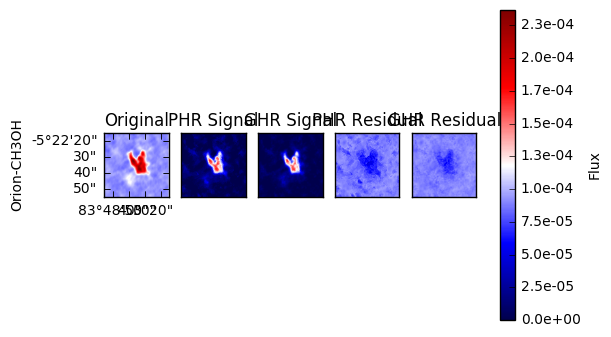

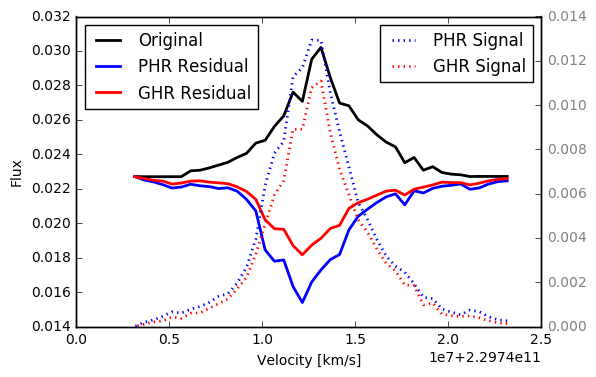

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 103 ms
1.00561759766e-06 8.99479067679e-07 [1, 3.0, 3.0]
INFO: Iteration: 1000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.99904e-06 SNR = 2.22244651138 [acalib.core.compact_rep]
INFO: Criterion Met: SNR=1.11744717034<1.118 [acalib.core.compact_rep]
CPU times: user 18.7 s, sys: 8 ms, total: 18.7 s
Wall time: 18.7 s


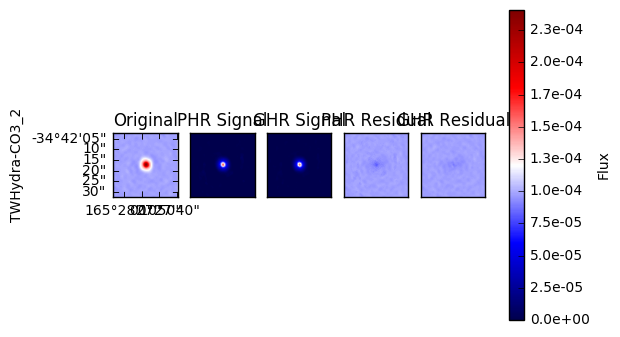

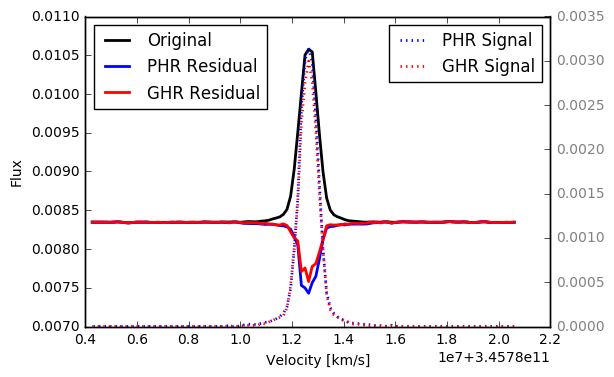

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/mauricio/scm/acalib-maray/acalib/core/compact_rep.py:101: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]
CPU times: user 1.45 s, sys: 360 ms, total: 1.81 s
Wall time: 1.41 s
1.46160601094e-07 9.18094227979e-08 [1, 2.0, 2.0]
INFO: Iteration: 1000 [acalib.core.compact_rep]
INFO: Maximum energy E = 2.98914e-07 SNR = 3.25580978493 [acalib.core.compact_rep]
INFO: Iteration: 2000 [acalib.core.compact_rep]
INFO: Maximum energy E = 2.38827e-07 SNR = 2.60133428343 [acalib.core.compact_rep]
INFO: Iteration: 3000 [acalib.core.compact_rep]
INFO: Maximum energy E = 2.04881e-07 SNR = 2.23158536266 [acalib.core.compact_rep]
INFO: Iteration: 4000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.83351e-07 SNR = 1.99708636611 [acalib.core.compact_rep]
INFO: Iteration: 5000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.69455e-07 SNR = 1.84573075688 [acalib.core.compact_rep]
INFO: Iteration: 6000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.6057e-07 SNR = 1.74895408854 [acalib.core.compact_rep]
INF

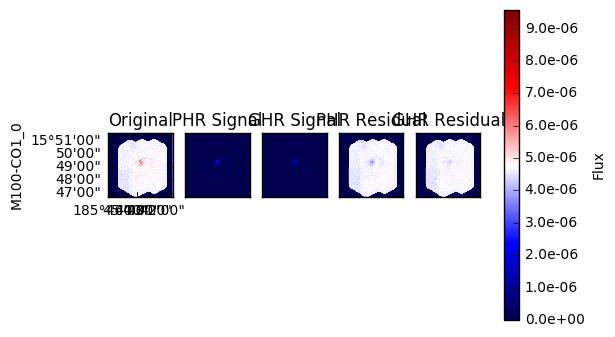

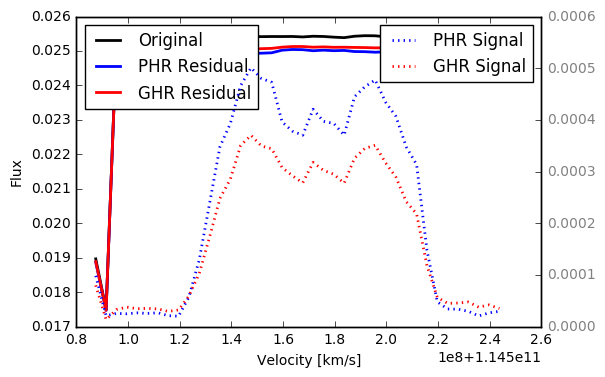

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/home/mauricio/scm/acalib-maray/acalib/core/compact_rep.py:101: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


CPU times: user 2.91 s, sys: 172 ms, total: 3.08 s
Wall time: 4.51 s
8.31225414913e-08 5.8952157086e-08 [1, 2.0, 2.0]
INFO: Iteration: 1000 [acalib.core.compact_rep]
INFO: Maximum energy E = 3.19102e-07 SNR = 5.41288982032 [acalib.core.compact_rep]
INFO: Iteration: 2000 [acalib.core.compact_rep]
INFO: Maximum energy E = 2.3099e-07 SNR = 3.91825597322 [acalib.core.compact_rep]
INFO: Iteration: 3000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.89681e-07 SNR = 3.21754135429 [acalib.core.compact_rep]
INFO: Iteration: 4000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.64414e-07 SNR = 2.78893475826 [acalib.core.compact_rep]
INFO: Iteration: 5000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.46769e-07 SNR = 2.48962629853 [acalib.core.compact_rep]
INFO: Iteration: 6000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.33821e-07 SNR = 2.2699964753 [acalib.core.compact_rep]
INFO: Iteration: 7000 [acalib.core.compact_rep]
INFO: Maximum energy E = 1.24059e-07 SNR = 2.10440

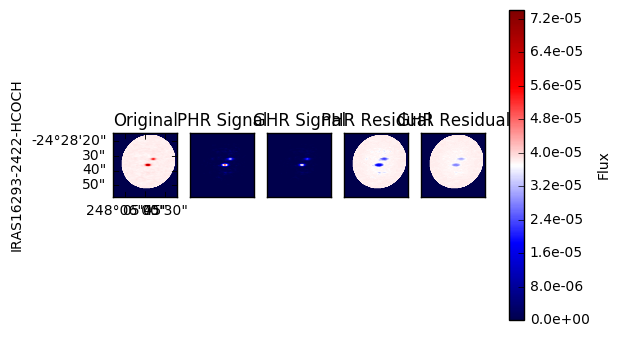

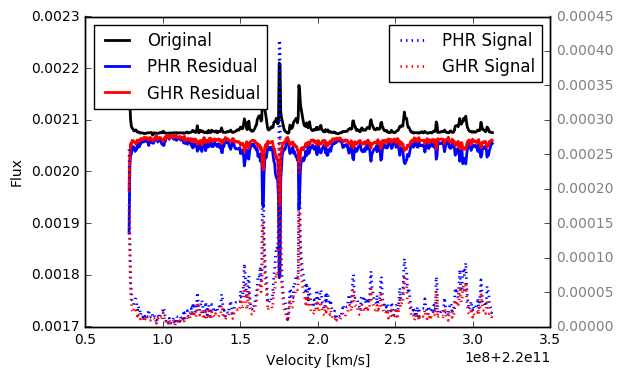

In [21]:
from acalib.core.compact_rep import *
from acalib.core.function_models import *
count=0
results=[]
syn_list=[]
ener_list =[]
resi_list=[]
for ffile in flist:
    # Preparing data
    cube    = acalib.load(DOWNLOADS_DIR+ffile[0])
    target  = ffile[1]
    (cube,ym,yf)=acalib.standarize(cube)
    mynoise=snr_table['RMS'][count]
    mythresh=mynoise*snr_table['SNR'][count]
    
    # Compute mould
    #spa=np.ceil((np.abs(cube.meta['BMIN']/cube.meta['CDELT1']) - 1)/2.0)
    #delta=[1,spa,spa]
    #P=precision_from_delta(delta,0.1)
    #mould=create_mould(P,delta)
    
    # Create representation
    %time (repP,synP,resP)=scatpix_detect(cube.data,threshold=mythresh,noise=mynoise,full_output=True)
    %time (rep,syn,res,ener,elist)=bubble_detect(cube.data,meta=cube.meta,threshold=mythresh,noise=mynoise,full_output=True,verbose=True)
    
    camera_ready_algo_result(target,cube,syn,res,synP,resP)
    results.append(rep)
    syn_list.append(syn)
    ener_list.append(elist)
    resi_list.append(res)
    count+=1

### Summary table

In [22]:
ghr_table=phr_table.copy()
rep_size=[]
for rep in results:
    rep_size.append(rep.as_array().size)
    #rep_size.append(res.size)
print(rep_size)
rbound=Column((np.array(rep_size)*100/np.array(bound))/100.0,name="Pts/Bound")
elms=Column(rep_size,name="Pts")
pval=np.array(rep_size)/(summary['Pixels']*(summary['Valid %']/100.0))
pval.name="Pts/Valid"
pthr=np.array(rep_size)/phr_table["Pts"]
pthr.name="Pts/Phr"
ghr_table.remove_column('Pts')
ghr_table.remove_column('Pts/Valid')
ghr_table.remove_column('Pts/Bound')
ghr_table.add_columns((elms,rbound,pthr,pval))
ghr_table

[7026, 1550, 12098, 34511]


Name,RMS,SNR,Pts,Pts/Bound,Pts/Phr,Pts/Valid
bytes100,float64,float64,int64,float64,float64,float64
Orion-CH3OH,2.60771895779e-06,1.01,7026,0.104892286102,0.12554499321,0.0171365853659
TWHydra-CO3_2,8.99479067679e-07,1.118,1550,0.0599613152805,0.0651369978148,0.00131355932203
M100-CO1_0,9.18094227979e-08,1.592,12098,0.116767045016,0.118735891648,0.00145364136079
IRAS16293-2422-HCOCH,5.8952157086e-08,1.41,34511,0.0991279520661,0.105202350904,0.00276328516341


In [23]:
ascii.write(ghr_table,format='latex')

\begin{table}
\begin{tabular}{ccccccc}
Name & RMS & SNR & Pts & Pts/Bound & Pts/Phr & Pts/Valid \\
Orion-CH3OH & 2.60771895779e-06 & 1.01 & 7026 & 0.104892286102 & 0.12554499321 & 0.0171365853659 \\
TWHydra-CO3_2 & 8.99479067679e-07 & 1.118 & 1550 & 0.0599613152805 & 0.0651369978148 & 0.00131355932203 \\
M100-CO1_0 & 9.18094227979e-08 & 1.592 & 12098 & 0.116767045016 & 0.118735891648 & 0.00145364136079 \\
IRAS16293-2422-HCOCH & 5.8952157086e-08 & 1.41 & 34511 & 0.0991279520661 & 0.105202350904 & 0.00276328516341 \\
\end{tabular}
\end{table}


## Save the results!

In [26]:
from astropy.nddata import NDData
ascii.write(ghr_table, 'GHR-Summary.dat')
ascii.write(phr_table, 'PHR-Summary.dat')
ascii.write(summary,'Data-Summary.dat')
ascii.write(snr_table,'SNR-Summary.dat')
for i in range(len(flist)):
    # Convert Results to savable table
    rep=results[i]['center'].data
    ffile=flist[i]
    name=ffile[1]
    cube = acalib.load(DOWNLOADS_DIR+ffile[0])
    ascii.write(rep,"REP-"+name+".dat")
    img=syn_list[i]
    hdu=acalib.Data_to_HDU(acalib.Data(img,wcs=cube.wcs,meta=cube.meta,mask=cube.mask),primary=True)
    hdu.writeto("SYN-"+name+".fits",clobber=True)
    img=resi_list[i]
    hdu=acalib.Data_to_HDU(acalib.Data(img,wcs=cube.wcs,meta=cube.meta,mask=cube.mask),primary=True)
    hdu.writeto("RES-"+name+".fits",clobber=True)

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


### Differences between representations

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


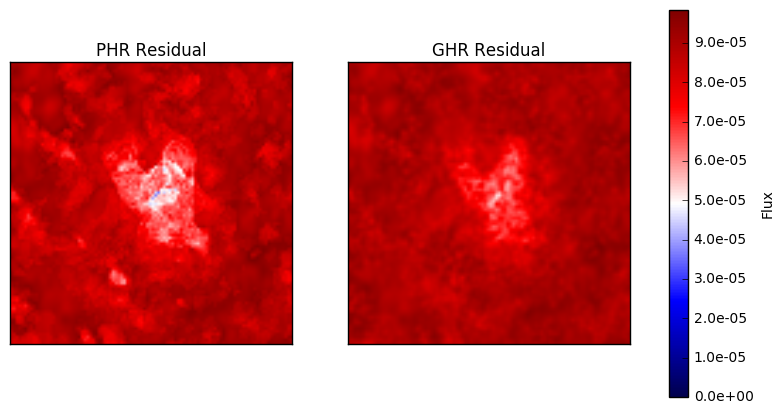

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


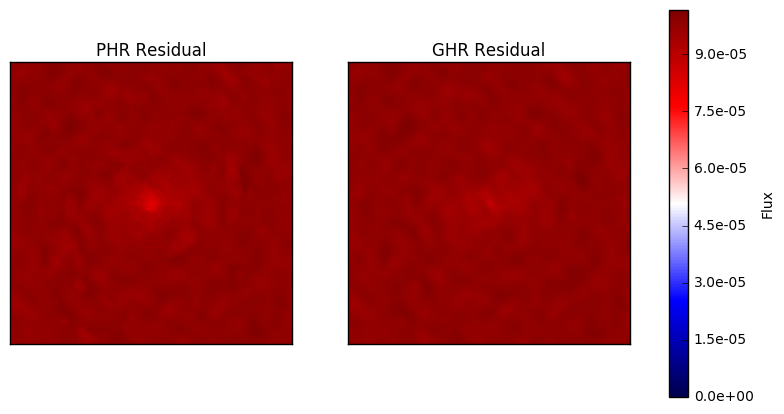

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/mauricio/scm/acalib-maray/acalib/core/compact_rep.py:101: RuntimeWarning: invalid value encountered in greater
  ff=np.where(data>threshold)


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


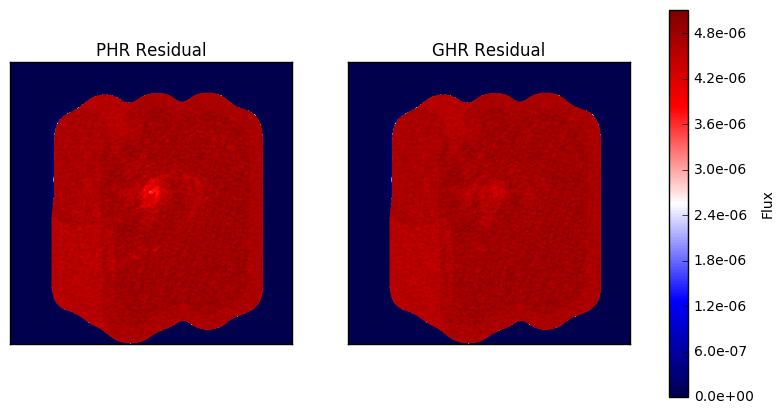

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


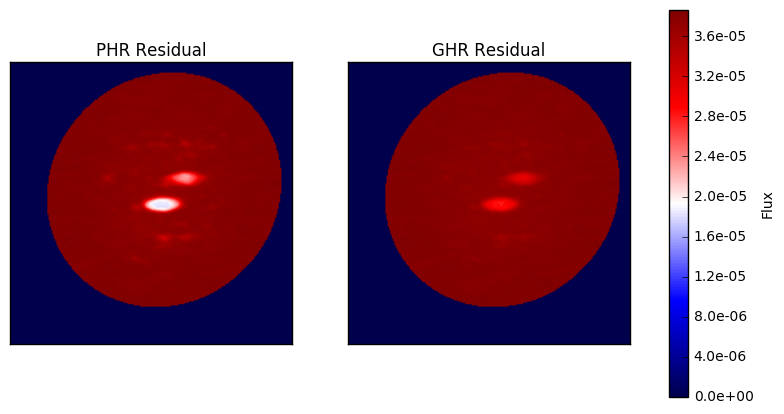

In [27]:

cmap="seismic"
origin="lower"

for ite in range(len(results)):
    (filename,target)=flist[ite]
    cube = acalib.load(DOWNLOADS_DIR+filename)
    target  = ffile[1]
    (cube,ym,yf)=acalib.standarize(cube)
    mynoise=snr_table['RMS'][ite]
    mythresh=mynoise*snr_table['SNR'][ite]
    resBub=resi_list[ite]
    (repPhb,synPhb,resPhb)=scatpix_detect(cube.data,threshold=mythresh,noise=mynoise,full_output=True)
    #resPhb2D= np.sum(resPhb.data,axis=(0))
    resPhb2D=acalib.moment0(resPhb,wcs=cube.wcs).data
    #resBub2D= np.sum(resBub.data,axis=(0))
    resBub2D=acalib.moment0(resBub,wcs=cube.wcs).data
    #phbmean=resPhb2D[resPhb2D>0].mean()
    #bubmean=resBub2D[resBub2D>0].mean()
    fig=plt.figure(figsize=(10,5))
    vmax=np.nanmax(resBub2D)
    vmin=0.0
    ax1=plt.subplot(1,2,1)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("PHR Residual")
    ob=ax1.imshow(resPhb2D,vmax=vmax,vmin=vmin,origin=origin,cmap=cmap)
    ax2=plt.subplot(1,2,2)
    ax2.imshow(resBub2D,vmax=vmax,vmin=vmin,origin=origin,cmap=cmap)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title("GHR Residual")
    cb=fig.colorbar(ob,ax=[ax1,ax2], format=ticker.FuncFormatter(fmt))
    cb.set_label("Flux")
    plt.show()